## Agent implementation
Let's see how to implement an agent using Core components.

In [ ]:
import sys
sys.path.append("..")

from dataclasses import dataclass
import datetime, random
from autogen_core import AgentId, MessageContext, RoutedAgent, message_handler
from autogen_core import SingleThreadedAgentRuntime
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.messages import TextMessage
from autogen_core.models import ChatCompletionClient
from rich import print
from functools import partial
from model_clients.azure import get_model
from typing_extensions import Annotated

We define the types that will act as messages in the workflow conversation

In [ ]:
@dataclass
class CancellationMessage:
    reservation_id: str

@dataclass
class ReservationMessage:
    info: str
    date: datetime

An agent is a class that inherits from RoutedAgent and maps one or more handler using the [@message_handler](https://microsoft.github.io/autogen/stable/reference/python/autogen_core.html#autogen_core.message_handler) decorator.  

The type of the message is used to identiy the correct handler, if you want to use different handlers with the same message type
you can use the [match](https://microsoft.github.io/autogen/stable/user-guide/core-user-guide/framework/message-and-communication.html#routing-messages-of-the-same-type) parameter of the message_handler decorator.

In [ ]:
class ReservationAgent(RoutedAgent):
    def __init__(self) -> None:
        super().__init__(description="An agent that handles reservations")
        print(f"[yellow]{self.id.type} initialized[/yellow]")

    @message_handler()
    async def handle_cancellation(self, message: CancellationMessage, ctx: MessageContext) -> None:
        print(f"[green]{self.id.type} received cancellation message for reservation: {message.reservation_id}[/green]")

    @message_handler
    async def handle_reservation(self, message: ReservationMessage, ctx: MessageContext) -> None:
        print(f"[cyan]{self.id.type} received reservation message for date: {message.date} with info: {message.info}[/cyan]")

Now that we have our Reservation agent, it's time to let the runtime know about it.

In [ ]:
# Create the runtime
runtime = SingleThreadedAgentRuntime()
# Register the agent with the runtime
await ReservationAgent.register(
    runtime, type="reservation_agent", factory=lambda: ReservationAgent()
)

Let's start the runtime, send a direct message to the agent and see the output.  

Note that:  

1. The Agent is created **after** the message has been posted (lazy loading)
2. We are sending direct messages using the [send_message](https://microsoft.github.io/autogen/stable/reference/python/autogen_core.html#autogen_core.AgentRuntime.send_message) method.

In [ ]:
runtime.start()
# create message and target agent_id
message=ReservationMessage(info="I want a table for today at 7 PM.", date="2021-10-10T19:00:00")
agent_id=AgentId(type="reservation_agent", key="default")

# send reservation message to the target agent
print(f"Sending reservation message to: {agent_id}")
await runtime.send_message(message=message, recipient=agent_id)

# Send cancellation message (simple sytax)
await runtime.send_message(CancellationMessage(reservation_id=1234), AgentId("reservation_agent", "default"))

# Stop the agent runtime when all the messages are processed
await runtime.stop_when_idle()

At this point the runtime is stopped, but the agent instance is still loaded, we can check that by sending a new reservation message.  
Another test we can do is to change the AgentId key to see the runtime spinning up a new instance behind the scenes.

In [ ]:
runtime.start()
# Let's send another reservation message

message=ReservationMessage(info="I want a table for today at 7 PM.", date="2025-10-10T19:00:00")
agent_id=AgentId(type="reservation_agent", key="default")

# Send reservation message to the target agent, since the agent is already instantiate, it will process the message
print(f"Sending another reservation message to: {agent_id}")
await runtime.send_message(message=message, recipient=agent_id)

# We now send a reservation message to the same agent but with a different agent_id, this will create a new agent instance
message=ReservationMessage(info="I want a table for today at 9 PM.", date="2025-10-10T21:00:00")
new_agent_id=AgentId(type="reservation_agent", key="123")
print(f"[green]Sending another reservation message to: {new_agent_id}[/green]")
await runtime.send_message(message=message, recipient=new_agent_id)

await runtime.stop_when_idle()


Let's now relase all the runtime resources

In [ ]:
await runtime.close()

### Using AssistantAgent inside a custom Agent
If your custom agent needs to interact with tools, it could make sense to rely on `AssistantAgent` to handle the conversation between the LLM and its tools
instead of writing all the logic related to function call handling.

Let's see the example described in the following sketch  

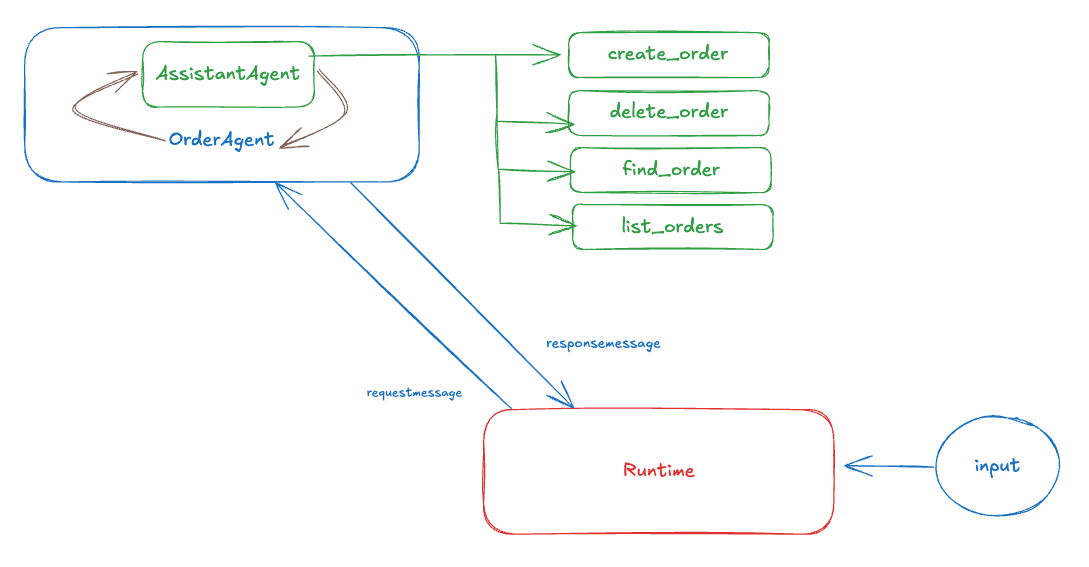

In [ ]:
from typing import List

# Define the dataclasses for the messages
@dataclass
class RequestMessage:
    content: str

@dataclass
class ResponseMessage:
    content: str


async def create_order(article: Annotated[str, "The name of the article to order"], quantity: Annotated[int, "The quantity to order"]) -> Annotated[int, "The order id"]:
    """Create an order for a given article and quantity."""
    
    print(f"Creating order for article: {article} and quantity: {quantity}")

    # Saves the order        
    order_id = random.randint(1000, 9999)        
    OrderAgent._orders[order_id] = {"article": article, "quantity": quantity}
    return order_id

# Define the agent in charge of handling orders
class OrderAgent(RoutedAgent):     
    _orders = {}  

    def __init__(self, model_client:ChatCompletionClient) -> None:
        super().__init__(description="An agent that specializes in weather")
        print(f"[yellow]{self.id.type} initialized[/yellow]")  
        
        self._agent= AssistantAgent(
                            name="order",
                            model_client=model_client,
                            tools=[
                                OrderAgent._create_order, 
                                OrderAgent._list_order, 
                                OrderAgent._list_all_orders,
                                OrderAgent._delete_order],
                            system_message="You are an AI Assistant that manages orders.",
                            reflect_on_tool_use=True,  
                        )
    # Important!: Looks like AutoGen is not able to handle instance methods, so we need to define the methods as static if we want to pack the tools inside the agent
    @staticmethod
    async def _create_order(article: Annotated[str, "The name of the article to order"], quantity: Annotated[int, "The quantity to order"]) -> Annotated[int, "The order id"]:
        """Create an order for a given article and quantity."""
        
        print(f"Creating order for article: {article} and quantity: {quantity}")

        # Saves the order        
        order_id = random.randint(1000, 9999)        
        OrderAgent._orders[order_id] = {"article": article, "quantity": quantity}
        return order_id
    
    @staticmethod
    async def _list_order(order_id: Annotated[int, "The id of the order"]) -> Annotated[str, "The order or 'not found'"]:
        """List an order for a given id."""
        
        print(f"Finding order for article id: {order_id}")
        
        if order_id in OrderAgent._orders:
            return OrderAgent._orders[order_id]
        else:
            return "not found"  

    @staticmethod
    async def _list_all_orders() -> Annotated[List[str]|str, "The list of orders or not found"]:
        """Returns the list of all placed orders."""
        
        print(f"Finding all orders...")
        return OrderAgent._orders.values() if OrderAgent._orders else "not found"
    
    @staticmethod
    async def _delete_order(order_id: Annotated[int, "The id of the order to delete"]) -> Annotated[bool, "True if the order was deleted, False in case of error"]:
        """Deletes an order."""
        
        print(f"Deleting order {order_id}...")
        return OrderAgent._orders.pop(order_id, "not found")
    

    # This method will handle the messages coming from the runtime
    @message_handler()
    async def handle_request(self, message: RequestMessage, ctx: MessageContext) -> ResponseMessage:
        print(f"[green]{self.id.type} received an order request: {message.content}[/green]")
        
        response =await self._agent.on_messages(
            [TextMessage(content=message.content, source="user")],
            ctx.cancellation_token)       
        
        return ResponseMessage(content=response.chat_message.content)

    

As before, we create a runtime, register the agent and send a message to the `OrderAgent`


In [143]:
runtime = SingleThreadedAgentRuntime()

# This time we need an LLM to pass to the agent since we want some tools to be called
model_client=get_model()

# Register the agent with the runtime
await OrderAgent.register(
    runtime, type="order_agent", factory=lambda: OrderAgent(model_client=model_client)
)

runtime.start()

while True:
    query=input("What do you want to do? (type exit to stop)")
    if query=="exit":
        break
    
    response:ResponseMessage= await runtime.send_message(RequestMessage(content=query), AgentId("order_agent","default"))
    print(response.content)
    
await runtime.stop_when_idle()
await runtime.close()

order_agent initialized

order_agent received an order request: i want buy an Iphone 16 for Iza, 300 Nvidia Stocks for Patrick and one 
gelato for corrado

Creating order for article: Iphone 16 and quantity: 1

Creating order for article: Nvidia Stock and quantity: 300

Creating order for article: Gelato and quantity: 1

Your orders have been placed successfully:

- One iPhone 16 for Iza (Order ID: 6982).
- 300 Nvidia Stocks for Patrick (Order ID: 5041).
- One gelato for Corrado (Order ID: 8219).

If you need any further assistance, feel free to ask!

order_agent received an order request: add another gelato for Iza

Creating order for article: Gelato and quantity: 1

Another gelato has been added for Iza (Order ID: 8290). If there's anything else you'd like to do, just let me 
know!

order_agent received an order request: what did i ordered so far?

Finding all orders...

Here's a summary of your orders so far:

1. iPhone 16: 1 unit
2. Nvidia Stocks: 300 units
3. Gelato: 2 units (one for Corrado and one for Iza)

Let me know if you need any additional information or assistance!

order_agent received an order request: Iza said he does not want the gelato anymore, can you delete her order and 
buy a pair of Prada shoes at the same price?

Deleting order 8290...

Creating order for article: Prada Shoes and quantity: 1

Iza's gelato order has been canceled, and a pair of Prada shoes has been ordered in its place (Order ID: 6521).

If there's anything else you need, just let me know!

order_agent received an order request: what are my orders?

Finding all orders...

Here's a summary of your current orders:

1. iPhone 16: 1 unit
2. Nvidia Stocks: 300 units
3. Gelato: 1 unit (for Corrado)
4. Prada Shoes: 1 pair

Let me know if there's anything else you'd like to do!

order_agent received an order request: ok, please change the number of stocks to 200, take care of all the 
necessary steps

Deleting order 5041...

Creating order for article: Nvidia Stock and quantity: 200

The order for 300 Nvidia stocks has been canceled, and a new order has been placed for 200 Nvidia stocks instead 
(Order ID: 7140). 

If there's anything else you need, feel free to ask!

order_agent received an order request: oh, think i've lost what i ordered so far, can you please help me?

Here's an updated summary of your current orders:

1. iPhone 16: 1 unit
2. Nvidia Stocks: 200 units (updated quantity)
3. Gelato: 1 unit (for Corrado)
4. Prada Shoes: 1 pair

Let me know if there's anything else you'd like to do!

order_agent received an order request: who ordered the shoes?

The Prada Shoes were ordered for Iza as a replacement for the gelato order that was canceled. If you need more 
information or assistance, feel free to ask!

order_agent received an order request: she said she changed her mind again and prefers to have ahuge pizza 
margherita instead of the shoes, can you do that?

Deleting order 6521...

Creating order for article: Huge Pizza Margherita and quantity: 1

The order for Prada Shoes has been canceled, and a Huge Pizza Margherita has been ordered for Iza instead (Order 
ID: 4855).

If there's anything else you'd like to do, just let me know!

order_agent received an order request: ok, please show me the status of all orders

Finding all orders...

Here's the current status of your orders:

1. iPhone 16: 1 unit
2. Gelato: 1 unit (for Corrado)
3. Nvidia Stocks: 200 units
4. Huge Pizza Margherita: 1 unit (for Iza)

Let me know if there's anything else you'd like to do!

order_agent received an order request: what is the order number for the iphone?

The order number for the iPhone 16 is 6982. If you need further assistance, feel free to ask!

order_agent received an order request: please delete it

Deleting order 6982...

The iPhone 16 order has been successfully canceled. If there's anything else you need, just let me know!

order_agent received an order request: and show me the recap

Finding all orders...

Here's the updated status of your current orders:

1. Gelato: 1 unit (for Corrado)
2. Nvidia Stocks: 200 units
3. Huge Pizza Margherita: 1 unit (for Iza)

Let me know if there's anything else you'd like to do!

order_agent received an order request: oh Atif is not happy, can you buy him some NVidia stocks?

How many Nvidia stocks would you like to purchase for Atif?

order_agent received an order request: 156

Creating order for article: Nvidia Stock and quantity: 156

156 Nvidia stocks have been ordered for Atif (Order ID: 5373). If there's anything else you'd like to do, feel free
to ask!